In [146]:
import os
import numpy as np
from numpy.lib.stride_tricks import as_strided
import time
import matplotlib.pyplot as plt
from scipy.spatial.distance import directed_hausdorff

import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import StepLR
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

from pytorch_lightning import LightningDataModule
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split

from monai.networks.nets import BasicUNet
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric, MeanIoU, HausdorffDistanceMetric
from monai.transforms import (
    AsDiscreted,
    Compose,
    Resized,
    EnsureChannelFirstd,
    LoadImaged,
    ScaleIntensityd,
    ToTensord,
    RandFlipd,
    RandZoomd, 
    ToTensord, 
    AsDiscreted,
    CenterSpatialCropd
)

In [147]:
# Custom dataset class for pytorch compatibility
# https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
class EndoVis2017Dataset(Dataset):
    def __init__(self, label_subdir=None):
        self.data = []

        if label_subdir is None:
            raise ValueError("You must specify a `label_subdir` for ground truth masks (e.g., 'instrument_seg_composite').")

        self.root_dir = "C:/Users/dsumm/OneDrive/Documents/UMD ENPM Robotics Files/BIOE658B (Intro to Medical Image Analysis)/Project/dataset/train/"
        self.label_subdir = label_subdir

        # Recursively walk through directory to find left frame image paths and GT image paths
        for subdir, dirs, files in os.walk(self.root_dir):
            if 'left_frames' in subdir:
                #print("Hit!")
                for file in sorted(files):
                    if file.endswith(('.png', '.jpg', '.jpeg')):                     
                        img_path = os.path.join(subdir, file)
                        #print(img_path)

                        gt_root = subdir.replace('left_frames', 'ground_truth')
                        mask_path = os.path.join(gt_root, self.label_subdir, file)

                        if os.path.exists(mask_path):
                            #print("Hit!")
                            self.data.append({"image": img_path, "label": mask_path})    # Dictionary for MONAI compatability

        transforms_list = [
            LoadImaged(keys=["image", "label"]),                        # Loads image data and metadata from file path dictionaries
            EnsureChannelFirstd(keys=["image", "label"]),               # Adjust or add the channel dimension of input data to ensure channel_first shape

            # Images are of nominal size 1280x1024 --> resizing for memory efficiency
            CenterSpatialCropd(keys=["image", "label"], roi_size=(1024, 1280)),         # Cropping background padding from images
            Resized(keys=["image", "label"], spatial_size=(256, 320)),                  # Imported images are of various sizes: standardize to 320,256

            # Apply data augmentation techniqes
            RandFlipd(keys=["image", "label"], prob=0.3, spatial_axis=1),               # Horizontal axis flip imposed w/ 30% prob
            #RandRotate90d(keys=["image", "label"], prob=0.3, max_k=3),                  # Random 90° rotation imposed w/ 30% prob
            RandZoomd(keys=["image", "label"], prob=0.3, min_zoom=0.75, mainput_zoom=1.25), # Zoom range (+/-25%) imposed w/ 30% prob
            #RandAdjustContrastd(keys=["image"], prob=0.3, gamma=(0.75, 1.25)),          # Contrast variation (+/-25%) imposed w/ 30% prob

            ScaleIntensityd(keys=["image"]),                            # Scale the intensity of input image to the value range 0-1
            ToTensord(keys=["image", "label"]),                         # Ensure data is of tensor type for pytorch usage
        ]

        # Additional conditional transforms based on label_subdir
        if label_subdir == "binary_composite":
            transforms_list.append(AsDiscreted(keys=["label"], threshold=0.5))         # Binary threshold for binary seg
        elif label_subdir == "part_seg_composite":
            transforms_list.append(AsDiscreted(keys=["label"], to_onehot=5))           # 5 individual class labels for instrument independent part seg
        elif label_subdir == "instrument_seg_composite":
            transforms_list.append(AsDiscreted(keys=["label"], to_onehot=8))            # 8 individual class labels for part independent instrument seg
        elif label_subdir == "instrument_part_seg_composite":
            transforms_list.append(AsDiscreted(keys=["label"], to_onehot=21))           # 26 individual class labels for instrument & part seg

        # Imposing MONAI transforms
        # https://docs.monai.io/en/stable/transforms.html
        self.transform = Compose(transforms_list)

    def __len__(self):
        # Returns number of imported samples
        length = len(self.data)
        return length

    def __getitem__(self, idx):
        # Return transformed sample from the dataset as dictated by the index
        sample = self.data[idx]
        return self.transform(sample)

In [148]:
class MONAIDataLoader(LightningDataModule):
    def __init__(self, dataset=None, batch_size: int = None, img_size: int = None, dimensions:int = None):
        super().__init__()
        if dataset is None:
            raise ValueError("No dataset given!")
        else:
            self.dataset = dataset

        self.train, self.val = random_split(self.dataset, [int(len(self.dataset) * 0.8), len(self.dataset) - int(len(self.dataset) * 0.8)])
        self.batch_size = batch_size
        #self.num_workers = 2
        self.pin_memory = True
        #self.persistent_workers = True
        print(f"Train dataset size: {len(self.train)}")
        print(f"Validation dataset size: {len(self.val)}")

    def setup(self, stage=None):
        # required by PyTorch Lightning
        pass

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=self.batch_size, pin_memory=self.pin_memory)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=self.batch_size, pin_memory=self.pin_memory)

    #def predict_dataloader(self):
    #    return DataLoader(self.test, batch_size=self.batch_size, num_workers=16)

In [149]:
class VGGEncoder(nn.Module):
    def __init__(self, pretrained=True, dropout_prob=0.3):
        super().__init__()
        #https://docs.pytorch.org/vision/0.12/generated/torchvision.models.vgg16.html
        vgg16_feats = models.vgg16(pretrained=pretrained).features
        print("Length of features in VGG16:", len(vgg16_feats))

        # Divide the layers based on VGG16 architecture
        self.encode1 = nn.Sequential(
            *vgg16_feats[:5],               # Conv1_1 to MaxPool1, 2 convs (64) + 2 relus + pool
            nn.Dropout2d(p=dropout_prob)
        )
        self.encode2 = nn.Sequential(
            *vgg16_feats[5:10],             # Conv2_1 to MaxPool2, 2 convs (128) + 2 relus + pool
            nn.Dropout2d(p=dropout_prob)
        )
        self.encode3 = nn.Sequential(
            *vgg16_feats[10:17],            # Conv3_1 to MaxPool3, 3 convs (256) + 3 relus + pool
            nn.Dropout2d(p=dropout_prob)
        )
        self.encode4 = nn.Sequential(
            *vgg16_feats[17:24],            # Conv4_1 to MaxPool4, 3 convs (512) + 3 relus + pool
            nn.Dropout2d(p=dropout_prob)
        )
        self.encode5 = nn.Sequential(
            *vgg16_feats[24:31],            # Conv5_1 to MaxPool5, 3 convs (512) + 3 relus + pool
            nn.Dropout2d(p=dropout_prob)
        )

    def forward(self, input):
        layer1 = self.encode1(input)
        layer2 = self.encode2(layer1)
        layer3 = self.encode3(layer2)
        layer4 = self.encode4(layer3)
        layer5 = self.encode5(layer4)
        return layer1, layer2, layer3, layer4, layer5

In [150]:
class Decoder(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels, use_skip=True):
        super().__init__()
        self.use_skip = use_skip

        if self.use_skip:
            conv_in = out_channels + skip_channels
        else:
            conv_in = out_channels

        #https://towardsdatascience.com/cook-your-first-u-net-in-pytorch-b3297a844cf3/
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.convblock = nn.Sequential(
            nn.Conv2d(conv_in, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, input, skip=True):
        input = self.upconv(input)
        if self.use_skip:
            input = torch.cat([input, skip], dim=1)
        return self.convblock(input)

In [151]:
# Using attention block from here
#https://github.com/PaddlePaddle/PaddleSeg/blob/release/2.10/paddleseg/models/attention_unet.py#L102
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()

        #F_g is gating signal channels
        #F_1 is skip connection channels
        #F_int is intermediate channels

        # Gating signal --> intermediate space
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0)
        )

        # Encoder feature map via skip --> intermediate space
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0)
        )

        # Reduces combined activation map to single channel mask (1) w/ sigmoid activation
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0),
            nn.Sigmoid()
        )

        # Learnable upconvolution layer to upsample `g1`
        self.upconv = nn.ConvTranspose2d(F_int, F_int, kernel_size=2, stride=2)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):            # g is decoder feature map, x is encoder skip cxn
        g1 = self.W_g(g)
        x1 = self.W_x(x)

        # Apply upconv to g1 to match the size of x1
        if g1.shape[2:] != x1.shape[2:]:
            g1 = self.upconv(g1)

        psi = self.relu(g1 + x1)    # sum in intermediate space
        psi = self.psi(psi)         # pass through attn mechanism
        return x * psi              # apply attention mask

In [152]:
class VGG16_AttnUNet(LightningModule):
    def __init__(self, img_size=(1, 3, 256, 320), batch_size=1, lr=0.001, num_classes=1):
        super().__init__()
        self.save_hyperparameters()
        self.num_classes = num_classes
        self.example_input_array = [torch.zeros(self.hparams.img_size)]

        # Bottleneck conv layers to refine features
        # Taken from https://github.com/usuyama/pytorch-unet
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),  #in_channels, out_channels
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.3), 
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.3)
        )

        self.encoder = VGGEncoder()
        self.decode_4 = Decoder(512, 512, 512)  # 512 -> 512
        self.decode_3 = Decoder(512, 256, 256)  # 512 -> 256
        self.decode_2 = Decoder(256, 128, 128)  # 256 -> 128
        self.decode_1 = Decoder(128, 64, 64)    # 128 -> 64
        self.decode_out = Decoder(64, 0, 64, use_skip=False)   # 64 -> 64

        self.attn_4 = AttentionBlock(F_g=512, F_l=512, F_int=256)  # for e4
        self.attn_3 = AttentionBlock(F_g=512, F_l=256, F_int=128)  # for e3
        self.attn_2 = AttentionBlock(F_g=256, F_l=128, F_int=64)   # for e2
        self.attn_1 = AttentionBlock(F_g=128, F_l=64,  F_int=32)   # for e1

        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

        # Using combined DICE and CE loss as loss function
        # Conditional loss function based on the number of classes
        if num_classes == 1:
            self.DICE_CE_Loss = DiceCELoss(
                include_background=False,  # Exclude background class
                sigmoid=True,  # Use softmax for multiclass segmentation
                softmax=False,  # Apply softmax for multiclass
                lambda_dice=1.0,  # Adjust the weight for Dice loss
                lambda_ce=1.0,  # Adjust the weight for Cross-Entropy loss
                reduction='mean'  # Use mean reduction
            )
        else:
            self.DICE_CE_Loss = DiceCELoss(
                include_background=False,  # Exclude background class
                sigmoid=False,  # Use softmax for multiclass segmentation
                softmax=True,  # Apply softmax for multiclass
                lambda_dice=1.0,  # Adjust the weight for Dice loss
                lambda_ce=1.0,  # Adjust the weight for Cross-Entropy loss
                reduction='mean'  # Use mean reduction
            )

        # Metric tracking
        self.dice_metric = DiceMetric(include_background=True, reduction="mean", ignore_empty=True)
        self.iou_metric = MeanIoU(include_background=True, reduction="mean", ignore_empty=True)
        self.dice_scores = []
        self.iou_scores = []
        self.train_losses = []
        self.val_losses = []
        self.last_image = []
        self.last_pred = []
        self.last_mask = []
        self.logged_epochs = []

    # Passes model inputs through U-net to get output predictions
    def forward(self, inputs):
        #print(f"Input: {inputs.shape}")

        # Spatial flow
        # Input:       (1, 3,   256, 320)
        # encode1 →    (1, 64,  128, 160)
        # encode2 →    (1, 128, 64,  80)
        # encode3 →    (1, 256, 32,  40)
        # encode4 →    (1, 512, 16,  20)
        # encode5 →    (1, 512, 8,   10)
        # bottleneck → (1, 512, 8,   10)
        # decode_4 →   (1, 512, 16,  20)
        # decode_3 →   (1, 256, 32,  40)
        # decode_2 →   (1, 128, 64,  80)
        # decode_1 →   (1, 64,  128, 160)
        # decode_out → (1, 64,  256, 320)
        # final_conv → (1, 1,   256, 320)

        # Encoder
        e1, e2, e3, e4, e5 = self.encoder(inputs)
        # print(f"Encode1: {e1.shape}")
        # print(f"Encode2: {e2.shape}")
        # print(f"Encode3: {e3.shape}")
        # print(f"Encode4: {e4.shape}")
        # print(f"Encode5: {e5.shape}")

        # Bottleneck
        bottleneck_out = self.bottleneck(e5)
        #print(f"Bottleneck: {bottleneck_out.shape}")

        # Decoder
        e4_attn = self.attn_4(bottleneck_out, e4)
        d5 = self.decode_4(bottleneck_out, e4_attn)
        #print(f"Decode4: {d5.shape}")
        e3_attn = self.attn_3(d5, e3)
        d4 = self.decode_3(d5, e3_attn)
        #print(f"Decode3: {d4.shape}")
        e2_attn = self.attn_2(d4, e2)
        d3 = self.decode_2(d4, e2_attn)
        #print(f"Decode2: {d3.shape}")
        e1_attn = self.attn_1(d3, e1)
        d2 = self.decode_1(d3, e1_attn)
        #print(f"Decode1: {d2.shape}")
        d1 = self.decode_out(d2, e1)
        #print(f"DecodeOut: {d1.shape}")

        outputs = self.final_conv(d1)
        #print(f"Final Output: {outputs.shape}")

        return outputs

    def training_step(self, batch, batch_idx):
        # Gets labels for input and corresponding ground truth
        inputs, gt_input = self._prepare_batch(batch)

        # Call forward pass
        outputs = self.forward(inputs)

        # Compute DICE & CE loss based on current params
        loss = self.DICE_CE_Loss(outputs, gt_input)

        # Log DICE loss with PyTorch Lightning logger
        self.log(f"Train_Dice_CE_loss", loss, on_epoch=True, prog_bar=True)

        # Append train loss at the end of each epoch
        if batch_idx == len(batch) - 1:
            self.train_losses.append(loss.item())

        return loss

    def validation_step(self, batch, batch_idx):

        # Gets labels for input and corresponding ground truth
        inputs, gt_input = self._prepare_batch(batch)
        outputs = self.forward(inputs)
        loss = self.DICE_CE_Loss(outputs, gt_input)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)

        if self.hparams.num_classes == 1:
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            # Ensure ground truth is binary (i.e., 0 or 1)
            gt_input = (gt_input > 0.5).float()  # Threshold the ground truth if needed

            intersection = (preds * gt_input).sum()
            union = preds.sum() + gt_input.sum()
            bin_dice_score = 2.0 * intersection / (union + 1e-8)  # Avoid division by zero
            # IoU score calculation for binary segmentation
            bin_iou_score = intersection / (union - intersection + 1e-8)  # Avoid division by zero

            self.log("val_dice", bin_dice_score, on_step=False, on_epoch=True, prog_bar=True)
            self.log("val_iou", bin_iou_score, on_step=False, on_epoch=True, prog_bar=True)

        else:
            probs = torch.softmax(outputs, dim=1)
            preds = torch.nn.functional.one_hot(torch.argmax(probs, dim=1), num_classes=self.num_classes)
            preds = preds.permute(0, 3, 1, 2).float()  # Shape: [B, C, H, W]

            self.dice_metric(y_pred=preds, y=gt_input)
            self.iou_metric(y_pred=preds, y=gt_input)

        if self.trainer.sanity_checking:
            return  # skip logging during sanity check

        # Append validation loss at the end of each epoch
        if batch_idx == len(batch) - 1:
            self.val_losses.append(loss.item())

            # For binary segmentation: apply sigmoid and threshold
            if self.hparams.num_classes == 1:
                outputs = torch.sigmoid(outputs)
                outputs = (outputs > 0.5).float()  # Convert probabilities to binary mask
                self.dice_scores.append(round(bin_dice_score.item(), 4))
                print("Dice", bin_dice_score)
                self.iou_scores.append(round(bin_iou_score.item(), 4))
                print("IOU", bin_iou_score)

            # For multiclass segmentation: apply softmax
            else:
                outputs = torch.softmax(outputs, dim=1)  # Apply softmax for multi-class outputs
                dice = self.dice_metric.aggregate()[0].item()
                print("Dice", round(dice, 4))
                iou = self.iou_metric.aggregate()[0].item()
                print("IOU", round(iou, 4))
                self.dice_metric.reset()
                self.iou_metric.reset()
                self.dice_scores.append(dice)
                self.iou_scores.append(iou)
                self.log("val_dice", dice, on_step=False, on_epoch=True, prog_bar=True)
                self.log("val_iou", iou, on_step=False, on_epoch=True, prog_bar=True)

            # Normalize and convert tensor to 3 channels (RGB) for visualization
            def process(last):
                # Detach from cpu to not interrupt training
                # https://stackoverflow.com/questions/63582590/why-do-we-call-detach-before-calling-numpy-on-a-pytorch-tensor
                last = last[0].detach().cpu()

                # Min max normalization
                # https://www.codecademy.com/article/normalization
                last= (last - last.min()) / (last.max() - last.min() + 1e-8)

                # If grayscale, reshape last image to RGB for display by replicating gray value twice
                # https://discuss.pytorch.org/t/convert-grayscale-images-to-rgb/113422
                return last.repeat(3, 1, 1) if last.shape[0] == 1 else last

            current_epoch = self.current_epoch
            total_epochs = self.trainer.max_epochs
            #print("TE", total_epochs)

            if current_epoch == 0 or current_epoch == total_epochs - 1 or current_epoch == total_epochs // 2:
                self.last_image.append(process(inputs))
                self.last_pred.append(process(outputs))
                self.last_mask.append(process(gt_input))
                self.logged_epochs.append(current_epoch)
                print(f"Logged image from epoch {current_epoch}")

        return loss

    #def predict_step(self, batch, batch_idx, dataloader_idx=0):
    #    return self(batch['image'])

    def configure_optimizers(self):
        #set optimizer
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=1e-4)
        scheduler = StepLR(optimizer, step_size=5, gamma=0.5)  # halve LR every 5 epochs
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'epoch',
                'frequency': 1
            }
        }

    def _prepare_batch(self, batch):
        return batch['image'], batch['label']

    # Plot training and val losses when needed
    def plot_losses(self):
        min_len = min(len(self.train_losses), len(self.val_losses))
        epochs = range(1, min_len + 1)

        # Plotting training vs validation loss
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, self.train_losses[:len(epochs)], label="Training Loss", color='blue')
        plt.plot(epochs, self.val_losses[:len(epochs)], label="Validation Loss", color='orange')
        plt.title("Training vs Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

    def plot_metrics(self):
        epochs = range(1, len(self.dice_scores) + 1)

        # Convert to CPU floats if necessary
        dice = [d.cpu().item() if torch.is_tensor(d) else d for d in self.dice_scores]
        iou = [i.cpu().item() if torch.is_tensor(i) else i for i in self.iou_scores]

        plt.figure(figsize=(10, 6))
        plt.plot(epochs, dice, label='Dice Coefficient')
        plt.plot(epochs, iou, label='IoU')
        plt.xlabel("Epochs")
        plt.ylabel("Score")
        plt.title("Validation Metrics Over Time")
        plt.legend()
        plt.show()

    def plot_result_by_epoch(self):
        total_epochs = len(self.last_image)

        if total_epochs < 5:
            print(f"Only {total_epochs} epochs recorded, plotting all.")
            selected_epochs = list(range(total_epochs))
        else:
            print(f"{total_epochs} epochs recorded, bug in code.")

        for epoch_idx in selected_epochs:
            epoch_num = self.logged_epochs[epoch_idx] if hasattr(self, "logged_epochs") else epoch_idx
            img = self.last_image[epoch_idx]
            pred = self.last_pred[epoch_idx]
            mask = self.last_mask[epoch_idx]

            fig, ax = plt.subplots(1, 3, figsize=(12, 4))

            ax[0].imshow(np.transpose(img.numpy(), (1, 2, 0)))
            ax[0].set_title(f"Epoch {epoch_num} - Image")
            ax[0].axis("off")

            if self.hparams.num_classes == 1:
                ax[1].imshow(np.transpose(pred.numpy(), (1, 2, 0)))
                ax[1].set_title(f"Epoch {epoch_num} - Prediction")
                ax[1].axis("off")

                ax[2].imshow(np.transpose(mask.numpy(), (1, 2, 0)))
                ax[2].set_title(f"Epoch {epoch_num} - Ground Truth")
                ax[2].axis("off")
            else:
                # Define the colormap and normalization
                num_classes = self.hparams.num_classes
                cmap = plt.get_cmap('viridis', num_classes)
                bounds = np.arange(num_classes + 1) - 0.5
                norm = plt.matplotlib.colors.BoundaryNorm(bounds, cmap.N)

                # Convert one-hot encoded predictions and masks to single-channel class labels
                pred_mask = torch.argmax(pred, dim=0).cpu().numpy()
                true_mask = torch.argmax(mask, dim=0).cpu().numpy()

                # Apply consistent colormap and normalization
                im1 = ax[1].imshow(pred_mask, cmap=cmap, norm=norm)
                ax[1].set_title(f"Epoch {epoch_num} - Prediction")
                ax[1].axis("off")

                im2 = ax[2].imshow(true_mask, cmap=cmap, norm=norm)
                ax[2].set_title(f"Epoch {epoch_num} - Ground Truth")
                ax[2].axis("off")

                im_for_cbar = im1  # just need one mappable

                # Adjust layout to leave space at the bottom
                fig.subplots_adjust(bottom=0.25) # tweak this if labels get cut off

                # Add a new axis below the plots for the colorbar
                cbar_ax = fig.add_axes([0.1, 0.1, 0.8, 0.10])  # [left, bottom, width, height]
                cbar = fig.colorbar(im_for_cbar, cax=cbar_ax, orientation='horizontal', ticks=np.arange(num_classes))

                # Add colorbar below the plots
                #cbar = fig.colorbar(im1, ax=ax.ravel().tolist(), orientation='horizontal',
                        #ticks=np.arange(num_classes), pad=0.15, fraction=0.05)

                # Set class labels
                if num_classes == 5:
                    cbar.ax.set_xticklabels(['Background', 'Shaft', 'Wrist', 'Claspers', 'Probe'])
                elif num_classes == 8:
                    cbar.ax.set_xticklabels(['Background', 'Bipolar Forceps', 'Prograsp Forceps', 'Large Needle Driver',
                                            'Vessel Sealer', 'Grasping Retractor', 'Monopolar Curved Scissors', 'Other'])

                    plt.setp(cbar.ax.get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")
                elif num_classes == 21:
                    cbar.ax.set_xticklabels([
                        "Background",
                        "Bipolar Forceps Shaft", "Bipolar Forceps Wrist", "Bipolar Forceps Claspers",
                        "Prograsp Forceps Shaft", "Prograsp Forceps Wrist", "Prograsp Forceps Claspers",
                        "Large Needle Driver Shaft", "Large Needle Driver Wrist", "Large Needle Driver Claspers",
                        "Vessel Sealer Shaft", "Vessel Sealer Wrist", "Vessel Sealer Claspers",
                        "Grasping Retractor Shaft", "Grasping Retractor Wrist", "Grasping Retractor Claspers",
                        "Monopolar Curved Scissors Shaft", "Monopolar Curved Scissors Wrist", "Monopolar Curved Scissors Claspers",
                        "Other Probe","Other Probe"
                    ])
                    plt.setp(cbar.ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        
                cbar.set_label('Class ID')

        plt.show()

In [153]:
# Generate datasets, loaders, and models for basic UNet
binary_endo_images = EndoVis2017Dataset(label_subdir='binary_composite')
part_seg_endo_images = EndoVis2017Dataset(label_subdir='part_seg_composite')
instr_seg_endo_images = EndoVis2017Dataset(label_subdir='instrument_seg_composite')
part_instr_seg_endo_images = EndoVis2017Dataset(label_subdir='instrument_part_seg_composite')

binary_endo_data = MONAIDataLoader(dataset=binary_endo_images, batch_size=10)  # batch size should be divisible, ie. 50 images and bs 20 wont work
part_seg_endo_data = MONAIDataLoader(dataset=part_seg_endo_images, batch_size=10)  
instr_seg_endo_data = MONAIDataLoader(dataset=instr_seg_endo_images, batch_size=10)  
part_instr_seg_endo_data = MONAIDataLoader(dataset=part_instr_seg_endo_images, batch_size=10)

binary_vgg16_AttnUNet_model = VGG16_AttnUNet(num_classes=1)
part_seg_vgg16_AttnUNet_model = VGG16_AttnUNet(num_classes=5)
instr_seg_vgg16_AttnUNet_model = VGG16_AttnUNet(num_classes=8)
part_instr_seg_vgg16_AttnUNet_model = VGG16_AttnUNet(num_classes=21)

Train dataset size: 1440
Validation dataset size: 360
Train dataset size: 1440
Validation dataset size: 360
Train dataset size: 1440
Validation dataset size: 360
Train dataset size: 1440
Validation dataset size: 360


The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.


Length of features in VGG16: 31
Length of features in VGG16: 31
Length of features in VGG16: 31
Length of features in VGG16: 31


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Checkpoint directory C:\Users\dsumm\OneDrive\Documents\UMD ENPM Robotics Files\BIOE658B (Intro to Medical Image Analysis)\Project\code\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name         | Type           | Params | Mode  | In sizes                               | Out sizes                                                                                 
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
0  | bottleneck   | Sequential     | 4.7 M  | train | [1, 512, 8, 10]                        | [1, 512, 8, 10]                                                                           
1  | encoder      | VGGEncoder     | 14.7 M | train | [1, 3, 256, 320]                       | [[1, 64, 1

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
single channel prediction, `include_background=False` ignored.
The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Dice metatensor(0.8651, device='cuda:0')
IOU metatensor(0.7623, device='cuda:0')
Logged image from epoch 0


Metric Train_Dice_CE_loss improved. New best score: 0.636


Validation: |          | 0/? [00:00<?, ?it/s]

Dice metatensor(0.8890, device='cuda:0')
IOU metatensor(0.8003, device='cuda:0')


Metric Train_Dice_CE_loss improved by 0.352 >= min_delta = 0.0. New best score: 0.283


Validation: |          | 0/? [00:00<?, ?it/s]

Dice metatensor(0.8949, device='cuda:0')
IOU metatensor(0.8097, device='cuda:0')


Metric Train_Dice_CE_loss improved by 0.057 >= min_delta = 0.0. New best score: 0.226


Validation: |          | 0/? [00:00<?, ?it/s]

Dice metatensor(0.9268, device='cuda:0')
IOU metatensor(0.8636, device='cuda:0')


Metric Train_Dice_CE_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.199


Validation: |          | 0/? [00:00<?, ?it/s]

Dice metatensor(0.9371, device='cuda:0')
IOU metatensor(0.8817, device='cuda:0')


Metric Train_Dice_CE_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.181


Validation: |          | 0/? [00:00<?, ?it/s]

Dice metatensor(0.9364, device='cuda:0')
IOU metatensor(0.8804, device='cuda:0')


Metric Train_Dice_CE_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.163


Validation: |          | 0/? [00:00<?, ?it/s]

Dice metatensor(0.9477, device='cuda:0')
IOU metatensor(0.9005, device='cuda:0')


Metric Train_Dice_CE_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.154


Validation: |          | 0/? [00:00<?, ?it/s]

Dice metatensor(0.9451, device='cuda:0')
IOU metatensor(0.8960, device='cuda:0')


Metric Train_Dice_CE_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.150


Validation: |          | 0/? [00:00<?, ?it/s]

Dice metatensor(0.9521, device='cuda:0')
IOU metatensor(0.9085, device='cuda:0')


Metric Train_Dice_CE_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.140


Validation: |          | 0/? [00:00<?, ?it/s]

Dice metatensor(0.9515, device='cuda:0')
IOU metatensor(0.9075, device='cuda:0')


Metric Train_Dice_CE_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.138


Validation: |          | 0/? [00:00<?, ?it/s]

Dice metatensor(0.9545, device='cuda:0')
IOU metatensor(0.9130, device='cuda:0')
Logged image from epoch 10


Metric Train_Dice_CE_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.131


Validation: |          | 0/? [00:00<?, ?it/s]

Dice metatensor(0.9563, device='cuda:0')
IOU metatensor(0.9163, device='cuda:0')


Metric Train_Dice_CE_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.127


Validation: |          | 0/? [00:00<?, ?it/s]

Dice metatensor(0.9532, device='cuda:0')
IOU metatensor(0.9106, device='cuda:0')


Metric Train_Dice_CE_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.124


Validation: |          | 0/? [00:00<?, ?it/s]

Dice metatensor(0.9577, device='cuda:0')
IOU metatensor(0.9188, device='cuda:0')


Validation: |          | 0/? [00:00<?, ?it/s]

Dice metatensor(0.9549, device='cuda:0')
IOU metatensor(0.9136, device='cuda:0')


Metric Train_Dice_CE_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.121


Validation: |          | 0/? [00:00<?, ?it/s]

Dice metatensor(0.9567, device='cuda:0')
IOU metatensor(0.9170, device='cuda:0')


Metric Train_Dice_CE_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.119


Validation: |          | 0/? [00:00<?, ?it/s]

Dice metatensor(0.9579, device='cuda:0')
IOU metatensor(0.9192, device='cuda:0')


Metric Train_Dice_CE_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.117


Validation: |          | 0/? [00:00<?, ?it/s]

Dice metatensor(0.9593, device='cuda:0')
IOU metatensor(0.9218, device='cuda:0')


Metric Train_Dice_CE_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.116


Validation: |          | 0/? [00:00<?, ?it/s]

Dice metatensor(0.9574, device='cuda:0')
IOU metatensor(0.9183, device='cuda:0')


Metric Train_Dice_CE_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.115


Validation: |          | 0/? [00:00<?, ?it/s]

Dice metatensor(0.9584, device='cuda:0')
IOU metatensor(0.9202, device='cuda:0')
Logged image from epoch 19


Metric Train_Dice_CE_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.114
`Trainer.fit` stopped: `max_epochs=20` reached.


Training time: 44.33 minutes


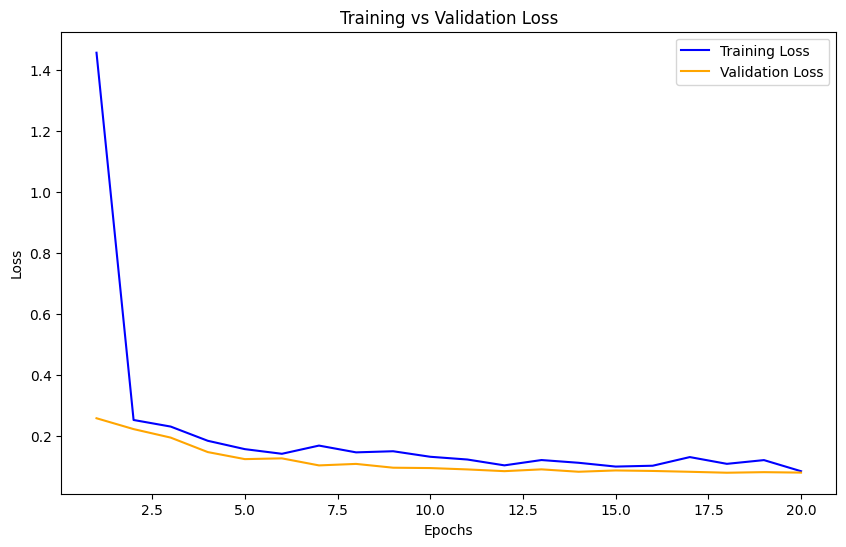

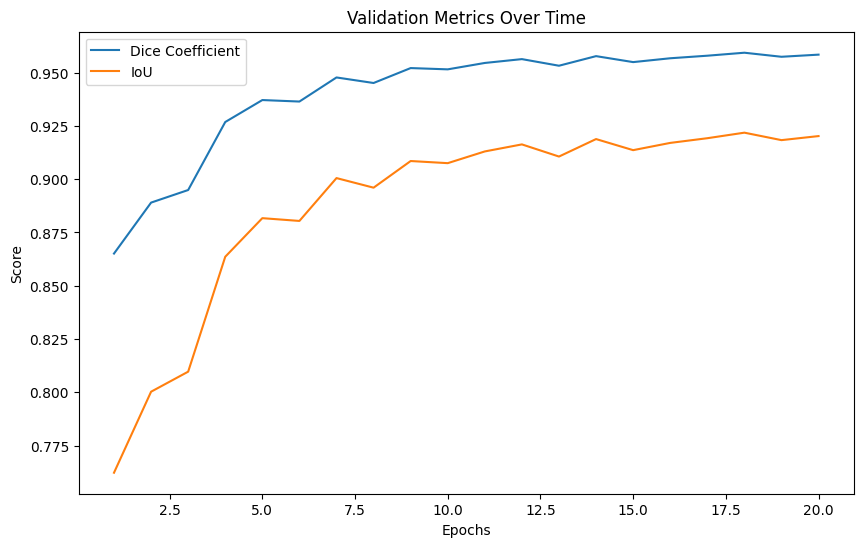

Only 3 epochs recorded, plotting all.


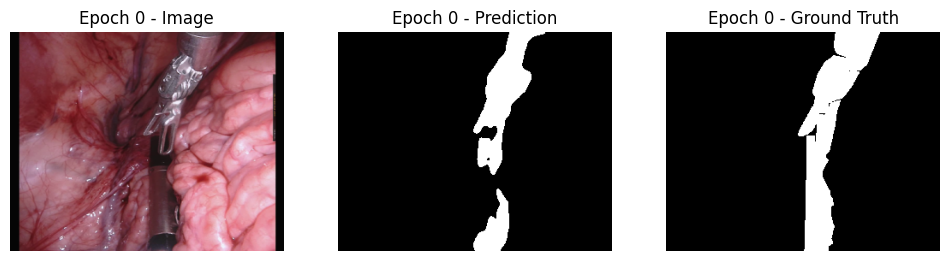

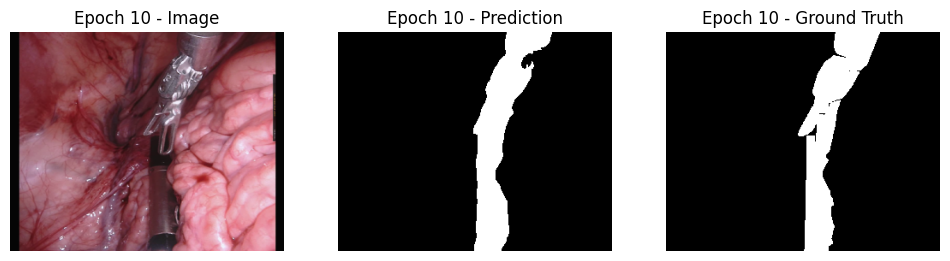

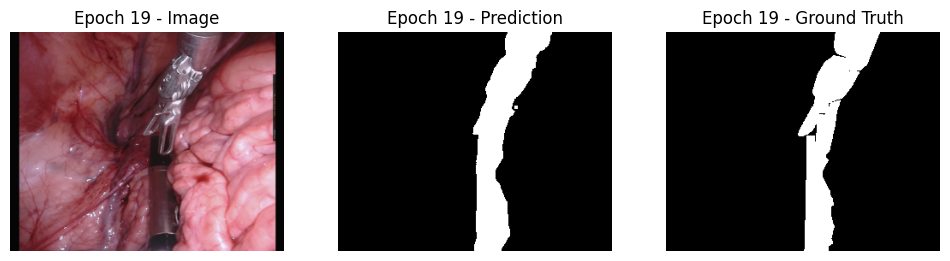

Model saved in the 'vgg16AttnUNetmodels' directory!


In [154]:
if __name__ == "__main__":

    logger = TensorBoardLogger("tb_logs", name="vgg16_AttnUNet_binary_seg")

    early_stop_callback = EarlyStopping(
        monitor="Train_Dice_CE_loss",          # metric name from self.log
        mode="min",                  # because lower loss is better
        patience=5,                  # epochs to wait before stopping
        verbose=True
    )

    checkpoint_callback = ModelCheckpoint(
        monitor="Train_Dice_CE_loss",
        mode="min",
        save_top_k=1,
        dirpath="checkpoints/",
        filename="best-part-seg-vgg16_AttnUNet",
    )

    trainer = Trainer(
        accelerator="gpu",
        max_epochs=20,
        #limit_train_batches=0.1,  # or 0.1 to use 10%
        logger=logger,
        callbacks=[early_stop_callback, checkpoint_callback],
    )

    start_train = time.time()
    trainer.fit(
        model=binary_vgg16_AttnUNet_model,
        datamodule=binary_endo_data
    )
    end_train = time.time()
    print(f"Training time: {(end_train - start_train)/60:.2f} minutes")

    # Plot the overlaid training and val loss curves per epoch
    binary_vgg16_AttnUNet_model.plot_losses()

    # Plot the IOU and DSC curves per epoch
    binary_vgg16_AttnUNet_model.plot_metrics()

    # Plot images from last epoch
    binary_vgg16_AttnUNet_model.plot_result_by_epoch()

    os.makedirs('vgg16AttnUNetmodels', exist_ok=True)
    # Define file names with paths
    binary_vgg16_AttnUNet_model_filename = 'vgg16AttnUNetmodels/binary_vgg16_AttnUNet_model.pth'
    # Save the model parameters
    torch.save(binary_vgg16_AttnUNet_model.state_dict(), binary_vgg16_AttnUNet_model_filename)
    print("Model saved in the 'vgg16AttnUNetmodels' directory!")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name         | Type           | Params | Mode  | In sizes                               | Out sizes                                                                                 
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
0  | bottleneck   | Sequential     | 4.7 M  | train | [1, 512, 8, 10]                        | [1, 512, 8, 10]                                                                           
1  | encoder      | VGGEncoder     | 14.7 M | train | [1, 3, 256, 320]                       | [[1, 64, 128, 160], [1, 128, 64, 80], [1, 256, 32, 40], [1, 512, 16, 20], [1, 512, 8, 10]]
2  | decode_4     | Decoder        | 8.1 M  | train | [[1, 512, 8, 10], [1, 512, 16, 20]]  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.2124
IOU 0.1787
Logged image from epoch 0


Metric Train_Dice_CE_loss improved. New best score: 1.560


Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.3855
IOU 0.3252


Metric Train_Dice_CE_loss improved by 0.523 >= min_delta = 0.0. New best score: 1.037


Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.5185
IOU 0.433


Metric Train_Dice_CE_loss improved by 0.096 >= min_delta = 0.0. New best score: 0.941


Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.5632
IOU 0.472


Metric Train_Dice_CE_loss improved by 0.041 >= min_delta = 0.0. New best score: 0.901


Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.6012
IOU 0.5096


Metric Train_Dice_CE_loss improved by 0.041 >= min_delta = 0.0. New best score: 0.860


Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.6223
IOU 0.5283


Metric Train_Dice_CE_loss improved by 0.060 >= min_delta = 0.0. New best score: 0.799


Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.6719
IOU 0.5714


Metric Train_Dice_CE_loss improved by 0.042 >= min_delta = 0.0. New best score: 0.757


Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.6945
IOU 0.5947


Metric Train_Dice_CE_loss improved by 0.041 >= min_delta = 0.0. New best score: 0.716


Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.727
IOU 0.6286


Metric Train_Dice_CE_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.701


Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.7297
IOU 0.6319


Metric Train_Dice_CE_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.675


Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.7435
IOU 0.649
Logged image from epoch 10


Metric Train_Dice_CE_loss improved by 0.034 >= min_delta = 0.0. New best score: 0.642


Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.7563
IOU 0.663


Metric Train_Dice_CE_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.627


Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.7667
IOU 0.6756


Metric Train_Dice_CE_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.617


Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.7657
IOU 0.6744


Metric Train_Dice_CE_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.605


Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.776
IOU 0.6865


Metric Train_Dice_CE_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.593


Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.783
IOU 0.6946


Metric Train_Dice_CE_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.573


Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.7926
IOU 0.7058


Metric Train_Dice_CE_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.569


Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.7939
IOU 0.7074


Metric Train_Dice_CE_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.562


Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.7948
IOU 0.7087


Metric Train_Dice_CE_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.556


Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.798
IOU 0.7128
Logged image from epoch 19


Metric Train_Dice_CE_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.545
`Trainer.fit` stopped: `max_epochs=20` reached.


Training time: 53.08 minutes


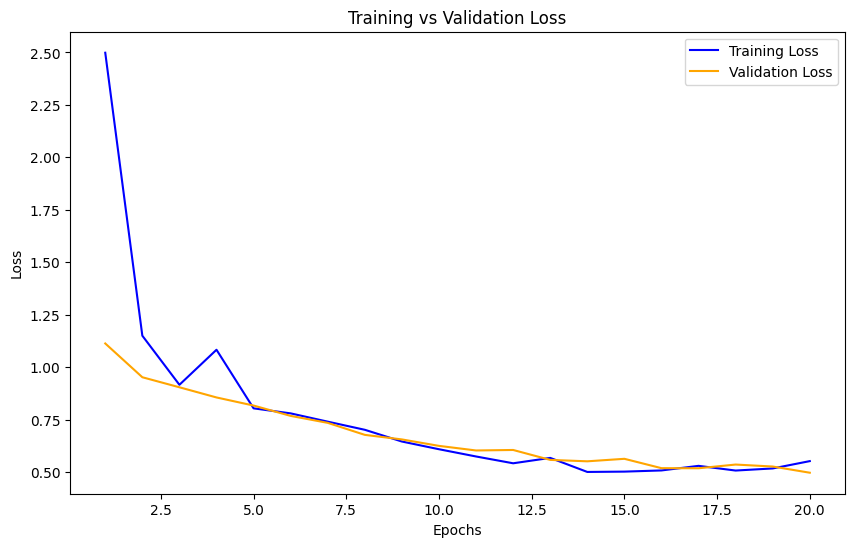

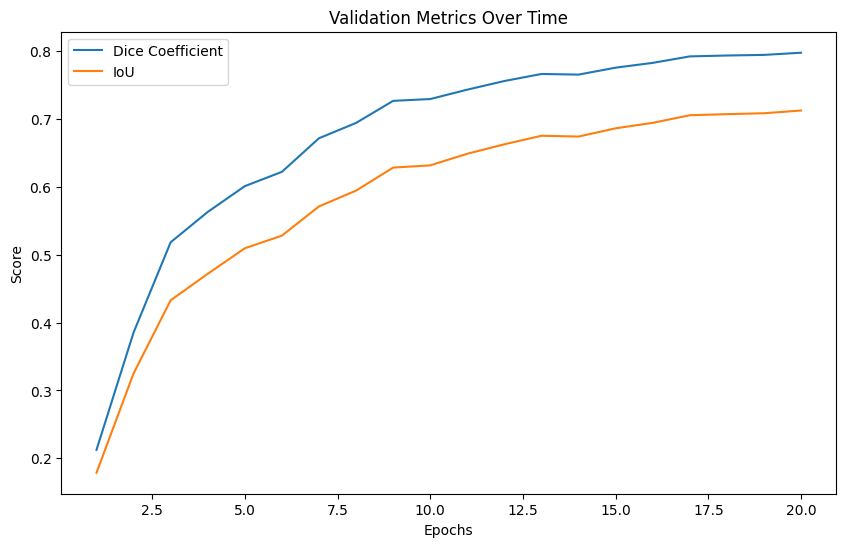

Only 3 epochs recorded, plotting all.


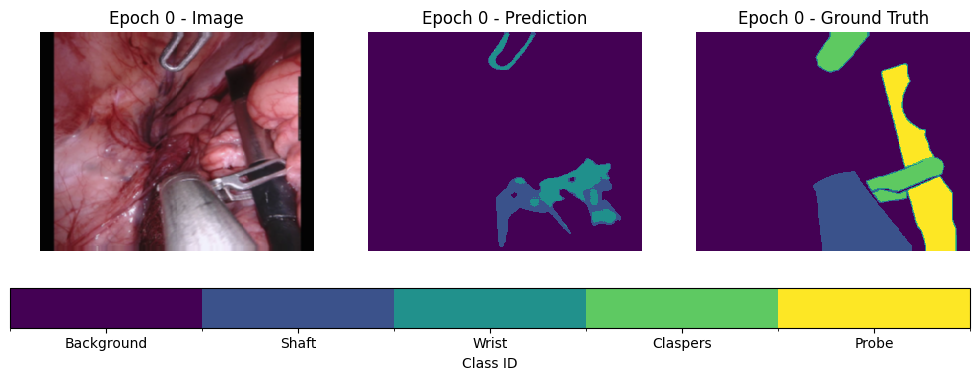

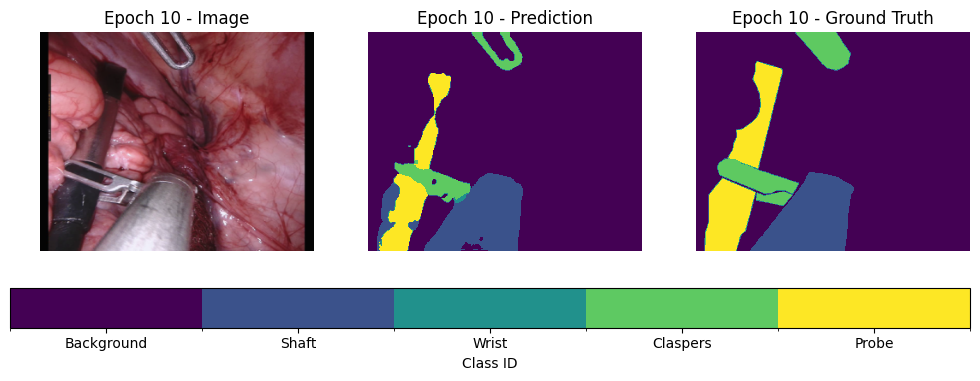

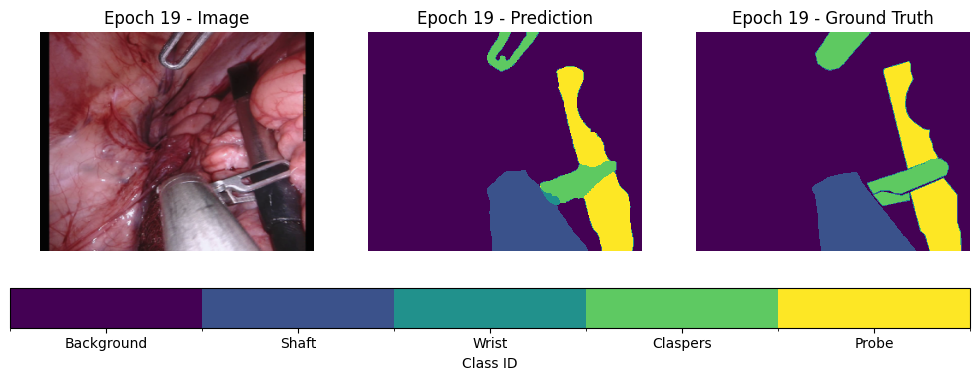

Model saved in the 'vgg16AttnUNetmodels' directory!


In [155]:
if __name__ == "__main__":

    logger = TensorBoardLogger("tb_logs", name="vgg16_AttnUNet_part_seg")

    early_stop_callback = EarlyStopping(
        monitor="Train_Dice_CE_loss",          # metric name from self.log
        mode="min",                  # because lower loss is better
        patience=5,                  # epochs to wait before stopping
        verbose=True
    )

    checkpoint_callback = ModelCheckpoint(
        monitor="Train_Dice_CE_loss",
        mode="min",
        save_top_k=1,
        dirpath="checkpoints/",
        filename="best-part-seg-vgg16_AttnUNet",
    )

    trainer = Trainer(
        accelerator="gpu",
        max_epochs=20,
        #limit_train_batches=0.1,  # or 0.1 to use 10%
        logger=logger,
        callbacks=[early_stop_callback, checkpoint_callback],
    )

    start_train = time.time()
    trainer.fit(
        model=part_seg_vgg16_AttnUNet_model,
        datamodule=part_seg_endo_data
    )
    end_train = time.time()
    print(f"Training time: {(end_train - start_train)/60:.2f} minutes")

    # Plot the overlaid training and val loss curves per epoch
    part_seg_vgg16_AttnUNet_model.plot_losses()

    # Plot the IOU and DSC curves per epoch
    part_seg_vgg16_AttnUNet_model.plot_metrics()

    # Plot images from last epoch
    part_seg_vgg16_AttnUNet_model.plot_result_by_epoch()    

    os.makedirs('vgg16AttnUNetmodels', exist_ok=True)
    # Define file names with paths
    part_seg_vgg16_AttnUNet_model_filename = 'vgg16AttnUNetmodels/part_seg_vgg16_AttnUNet_model.pth'
    # Save the model parameters
    torch.save(part_seg_vgg16_AttnUNet_model.state_dict(), part_seg_vgg16_AttnUNet_model_filename)
    print("Model saved in the 'vgg16AttnUNetmodels' directory!")


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Checkpoint directory C:\Users\dsumm\OneDrive\Documents\UMD ENPM Robotics Files\BIOE658B (Intro to Medical Image Analysis)\Project\code\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name         | Type           | Params | Mode  | In sizes                               | Out sizes                                                                                 
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
0  | bottleneck   | Sequential     | 4.7 M  | train | [1, 512, 8, 10]                        | [1, 512, 8, 10]                                                                           
1  | encoder      | VGGEncoder     | 14.7 M | train | [1, 3, 256, 320]                       | [[1, 64, 1

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.1802
IOU 0.1691
Logged image from epoch 0


Metric Train_Dice_CE_loss improved. New best score: 2.575


Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.1893
IOU 0.1783


Metric Train_Dice_CE_loss improved by 1.117 >= min_delta = 0.0. New best score: 1.458


Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.2517
IOU 0.2327


Metric Train_Dice_CE_loss improved by 0.173 >= min_delta = 0.0. New best score: 1.285


Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.2774
IOU 0.249


Metric Train_Dice_CE_loss improved by 0.035 >= min_delta = 0.0. New best score: 1.251


Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.2868
IOU 0.2572


Metric Train_Dice_CE_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.231


Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.3182
IOU 0.2765


Metric Train_Dice_CE_loss improved by 0.032 >= min_delta = 0.0. New best score: 1.199


Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.3381
IOU 0.2936


Metric Train_Dice_CE_loss improved by 0.026 >= min_delta = 0.0. New best score: 1.174


Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.3603
IOU 0.3103


Metric Train_Dice_CE_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.163


Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.3701
IOU 0.319


Metric Train_Dice_CE_loss improved by 0.017 >= min_delta = 0.0. New best score: 1.145


Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.3785
IOU 0.3262


Metric Train_Dice_CE_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.126


Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.3914
IOU 0.3376
Logged image from epoch 10


Metric Train_Dice_CE_loss improved by 0.034 >= min_delta = 0.0. New best score: 1.092


Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.41
IOU 0.3578


Metric Train_Dice_CE_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.075


Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.417
IOU 0.3645


Metric Train_Dice_CE_loss improved by 0.017 >= min_delta = 0.0. New best score: 1.057


Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.4306
IOU 0.3786


Metric Train_Dice_CE_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.048


Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.4361
IOU 0.3856


Metric Train_Dice_CE_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.037


Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.4383
IOU 0.3885


Metric Train_Dice_CE_loss improved by 0.024 >= min_delta = 0.0. New best score: 1.013


Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.4565
IOU 0.407


Metric Train_Dice_CE_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.004


Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.4604
IOU 0.4113


Metric Train_Dice_CE_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.993


Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.4656
IOU 0.417


Metric Train_Dice_CE_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.982


Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.4701
IOU 0.4232
Logged image from epoch 19


Metric Train_Dice_CE_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.980
`Trainer.fit` stopped: `max_epochs=20` reached.


Training time: 47.22 minutes


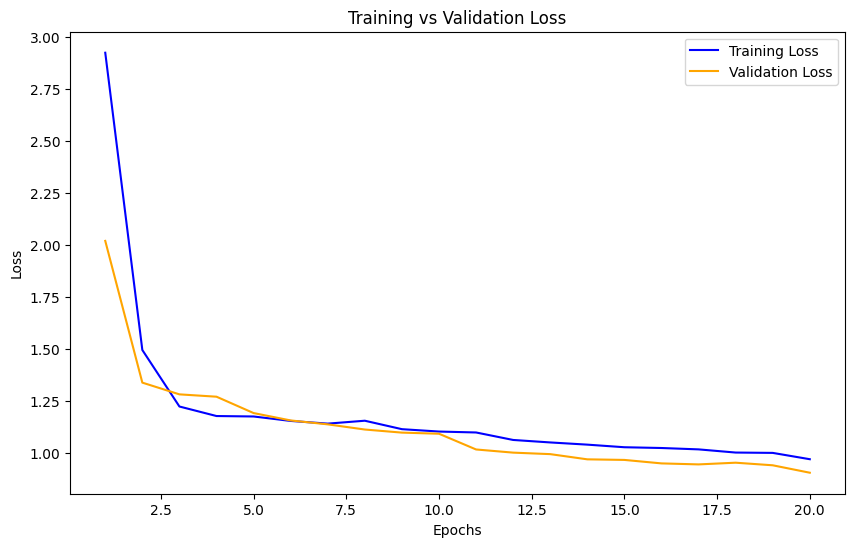

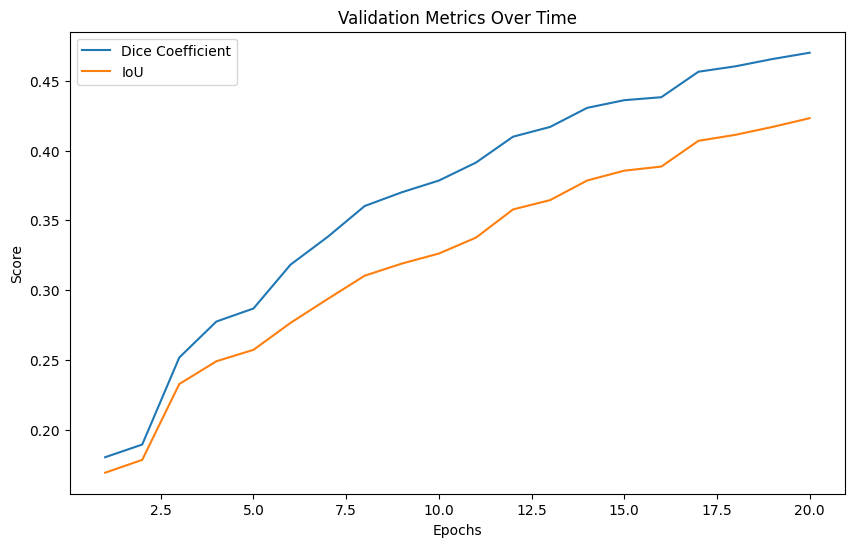

Only 3 epochs recorded, plotting all.


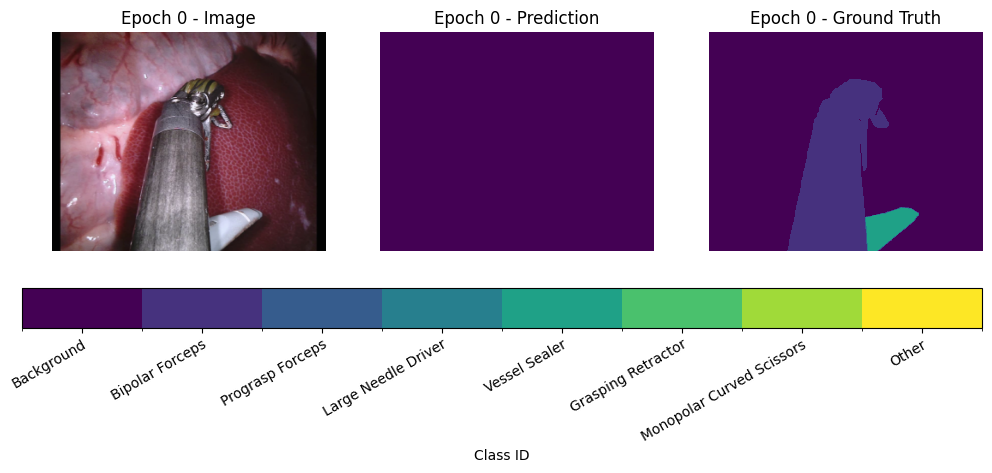

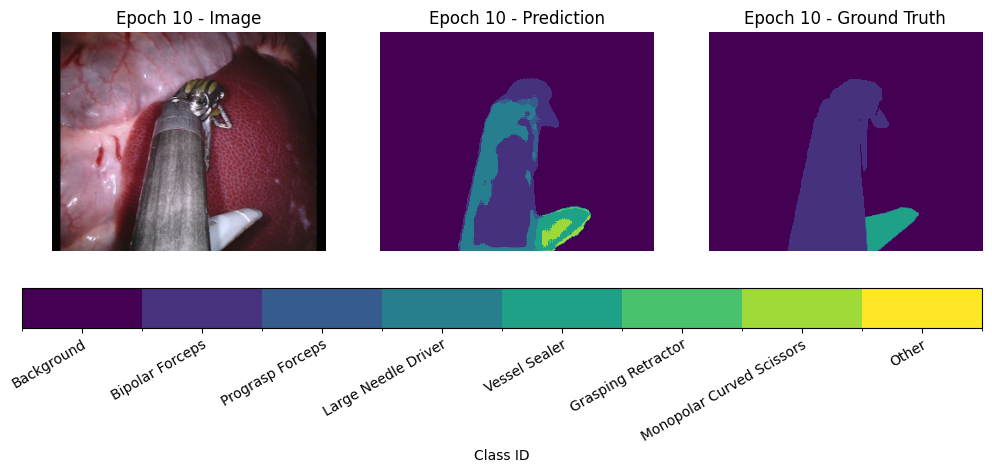

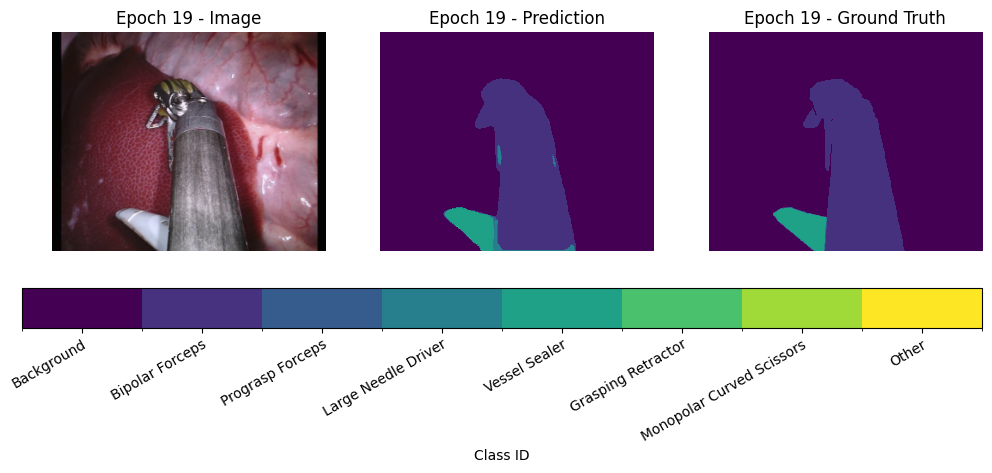

Model saved in the 'vgg16AttnUNetmodels' directory!


In [156]:
if __name__ == "__main__":

    logger = TensorBoardLogger("tb_logs", name="vgg16_AttnUNet_instrument_seg")

    early_stop_callback = EarlyStopping(
        monitor="Train_Dice_CE_loss",          # metric name from self.log
        mode="min",                  # because lower loss is better
        patience=5,                  # epochs to wait before stopping
        verbose=True
    )

    checkpoint_callback = ModelCheckpoint(
        monitor="Train_Dice_CE_loss",
        mode="min",
        save_top_k=1,
        dirpath="checkpoints/",
        filename="best-instrument-seg-vgg16_AttnUNet",
    )

    trainer = Trainer(
        accelerator="gpu",
        max_epochs=20,
        #limit_train_batches=0.1,  # or 0.1 to use 10%
        logger=logger,
        callbacks=[early_stop_callback, checkpoint_callback],
    )

    start_train = time.time()
    trainer.fit(
        model=instr_seg_vgg16_AttnUNet_model,
        datamodule=instr_seg_endo_data
    )
    end_train = time.time()
    print(f"Training time: {(end_train - start_train)/60:.2f} minutes")

    # Plot the overlaid training and val loss curves per epoch
    instr_seg_vgg16_AttnUNet_model.plot_losses()

    # Plot the IOU and DSC curves per epoch
    instr_seg_vgg16_AttnUNet_model.plot_metrics()

    # Plot images from last epoch
    instr_seg_vgg16_AttnUNet_model.plot_result_by_epoch()

    os.makedirs('vgg16AttnUNetmodels', exist_ok=True)
    # Define file names with paths
    instr_seg_vgg16_AttnUNet_model_filename = 'vgg16AttnUNetmodels/instr_seg_vgg16_AttnUNet_model.pth'
    # Save the model parameters
    torch.save(instr_seg_vgg16_AttnUNet_model.state_dict(), instr_seg_vgg16_AttnUNet_model_filename)
    print("Model saved in the 'vgg16AttnUNetmodels' directory!")


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Checkpoint directory C:\Users\dsumm\OneDrive\Documents\UMD ENPM Robotics Files\BIOE658B (Intro to Medical Image Analysis)\Project\code\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name         | Type           | Params | Mode  | In sizes                               | Out sizes                                                                                 
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
0  | bottleneck   | Sequential     | 4.7 M  | train | [1, 512, 8, 10]                        | [1, 512, 8, 10]                                                                           
1  | encoder      | VGGEncoder     | 14.7 M | train | [1, 3, 256, 320]                       | [[1, 64, 1

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.0765
IOU 0.0717
Logged image from epoch 0


Metric Train_Dice_CE_loss improved. New best score: 1.734


Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.0991
IOU 0.0912


Metric Train_Dice_CE_loss improved by 0.312 >= min_delta = 0.0. New best score: 1.422


Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.1259
IOU 0.1135


Metric Train_Dice_CE_loss improved by 0.017 >= min_delta = 0.0. New best score: 1.406


Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.1414
IOU 0.1245


Metric Train_Dice_CE_loss improved by 0.067 >= min_delta = 0.0. New best score: 1.339


Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.1597
IOU 0.1386


Metric Train_Dice_CE_loss improved by 0.031 >= min_delta = 0.0. New best score: 1.308


Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.1663
IOU 0.1443


Metric Train_Dice_CE_loss improved by 0.036 >= min_delta = 0.0. New best score: 1.272


Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.1846
IOU 0.1588


Metric Train_Dice_CE_loss improved by 0.024 >= min_delta = 0.0. New best score: 1.248


Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.1956
IOU 0.1673


Metric Train_Dice_CE_loss improved by 0.023 >= min_delta = 0.0. New best score: 1.225


Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.211
IOU 0.1794


Metric Train_Dice_CE_loss improved by 0.020 >= min_delta = 0.0. New best score: 1.205


Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.2231
IOU 0.1906


Metric Train_Dice_CE_loss improved by 0.020 >= min_delta = 0.0. New best score: 1.185


Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.229
IOU 0.1953
Logged image from epoch 10


Metric Train_Dice_CE_loss improved by 0.028 >= min_delta = 0.0. New best score: 1.156


Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.2485
IOU 0.2114


Metric Train_Dice_CE_loss improved by 0.025 >= min_delta = 0.0. New best score: 1.132


Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.258
IOU 0.2203


Metric Train_Dice_CE_loss improved by 0.054 >= min_delta = 0.0. New best score: 1.078


Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.2681
IOU 0.2296


Metric Train_Dice_CE_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.067


Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.2773
IOU 0.2385


Metric Train_Dice_CE_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.054


Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.2844
IOU 0.2458


Metric Train_Dice_CE_loss improved by 0.021 >= min_delta = 0.0. New best score: 1.033


Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.291
IOU 0.2529


Metric Train_Dice_CE_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.024


Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.2948
IOU 0.2564


Metric Train_Dice_CE_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.018


Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.2998
IOU 0.2617


Metric Train_Dice_CE_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.010


Validation: |          | 0/? [00:00<?, ?it/s]

Dice 0.2995
IOU 0.2616
Logged image from epoch 19


Metric Train_Dice_CE_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.006
`Trainer.fit` stopped: `max_epochs=20` reached.


Training time: 48.90 minutes


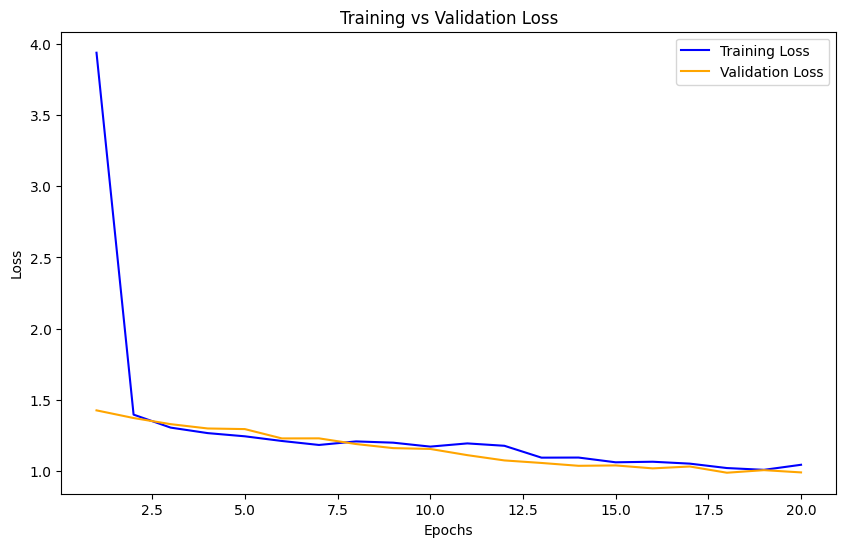

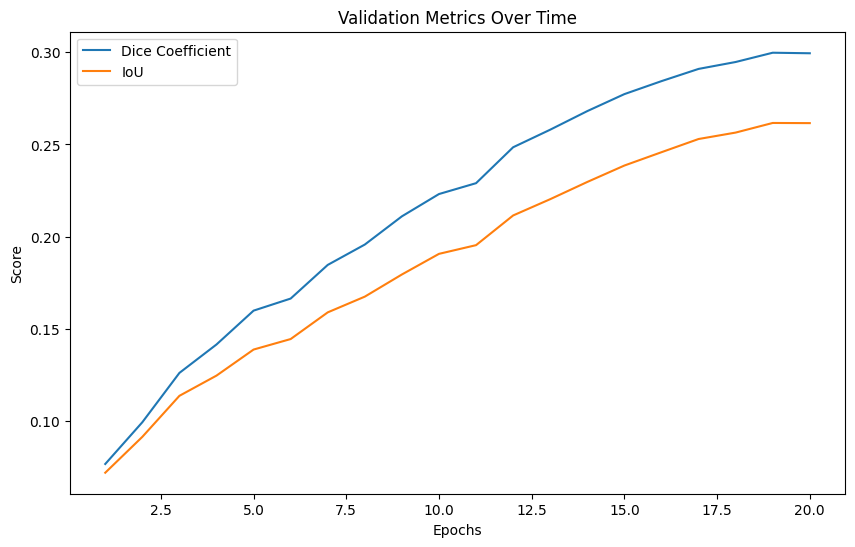

Only 3 epochs recorded, plotting all.


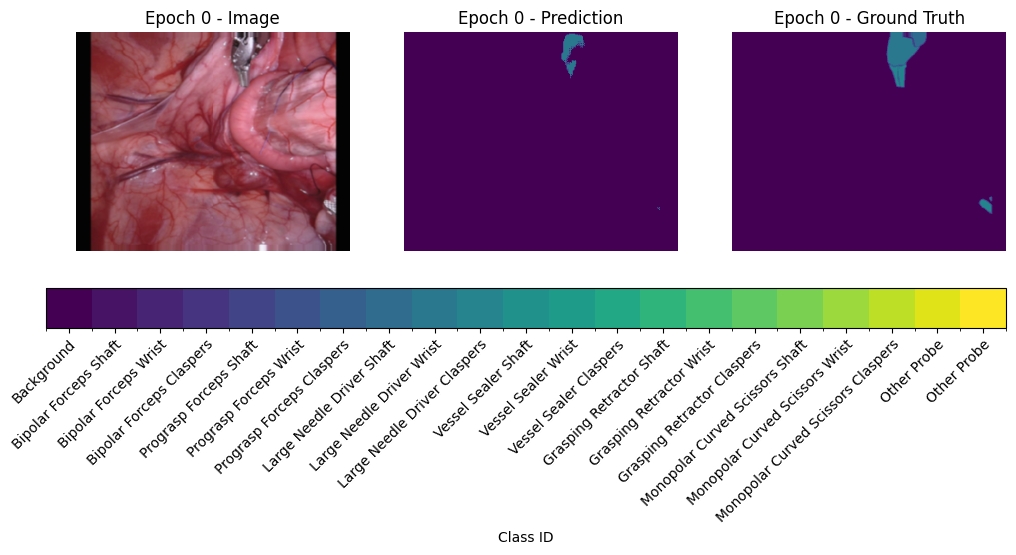

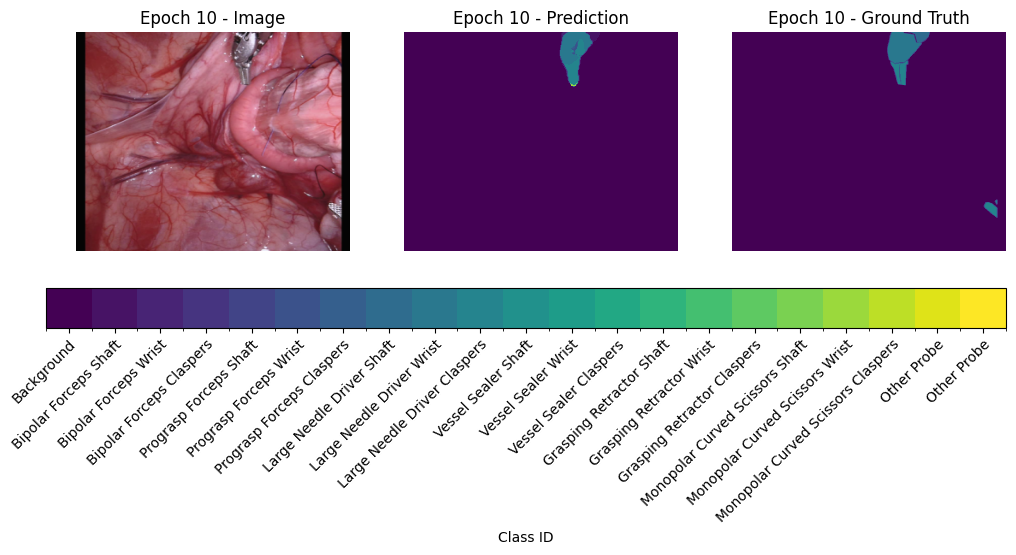

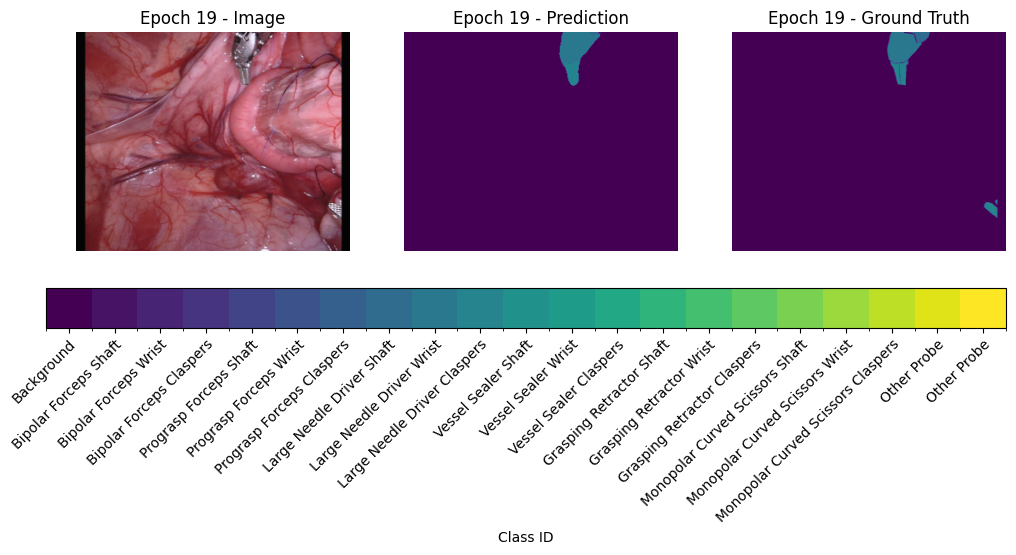

Model saved in the 'vgg16AttnUNetmodels' directory!


In [157]:
if __name__ == "__main__":

    logger = TensorBoardLogger("tb_logs", name="vgg16_AttnUNet_part_instrument_seg")

    early_stop_callback = EarlyStopping(
        monitor="Train_Dice_CE_loss",          # metric name from self.log
        mode="min",                  # because lower loss is better
        patience=5,                  # epochs to wait before stopping
        verbose=True
    )

    checkpoint_callback = ModelCheckpoint(
        monitor="Train_Dice_CE_loss",
        mode="min",
        save_top_k=1,
        dirpath="checkpoints/",
        filename="best-part-instrument-seg-vgg16_AttnUNet",
    )

    trainer = Trainer(
        accelerator="gpu",
        max_epochs=20,
        #limit_train_batches=0.1,  # or 0.1 to use 10%
        logger=logger,
        callbacks=[early_stop_callback, checkpoint_callback],
    )

    start_train = time.time()
    trainer.fit(
        model=part_instr_seg_vgg16_AttnUNet_model,
        datamodule=part_instr_seg_endo_data
    )
    end_train = time.time()
    print(f"Training time: {(end_train - start_train)/60:.2f} minutes")

    # Plot the overlaid training and val loss curves per epoch
    part_instr_seg_vgg16_AttnUNet_model.plot_losses()

    # Plot the IOU and DSC curves per epoch
    part_instr_seg_vgg16_AttnUNet_model.plot_metrics()

    # Plot images from last epoch
    part_instr_seg_vgg16_AttnUNet_model.plot_result_by_epoch()

    os.makedirs('vgg16AttnUNetmodels', exist_ok=True)
    part_instr_seg_vgg16_AttnUNet_model_filename = 'vgg16AttnUNetmodels/part_instr_seg_vgg16_AttnUNet_model.pth'
    torch.save(part_instr_seg_vgg16_AttnUNet_model.state_dict(), part_instr_seg_vgg16_AttnUNet_model_filename)
    print("Model saved in the 'vgg16AttnUNetmodels' directory!")